In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 25, 
      'axes.titlesize': 25, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 20 

res = pd.read_csv('../data/master_table.tsv', sep='\t')
print((res['padj-50'] < 0.05).sum())
print((res['padj-58'] < 0.05).sum())


1662
3618


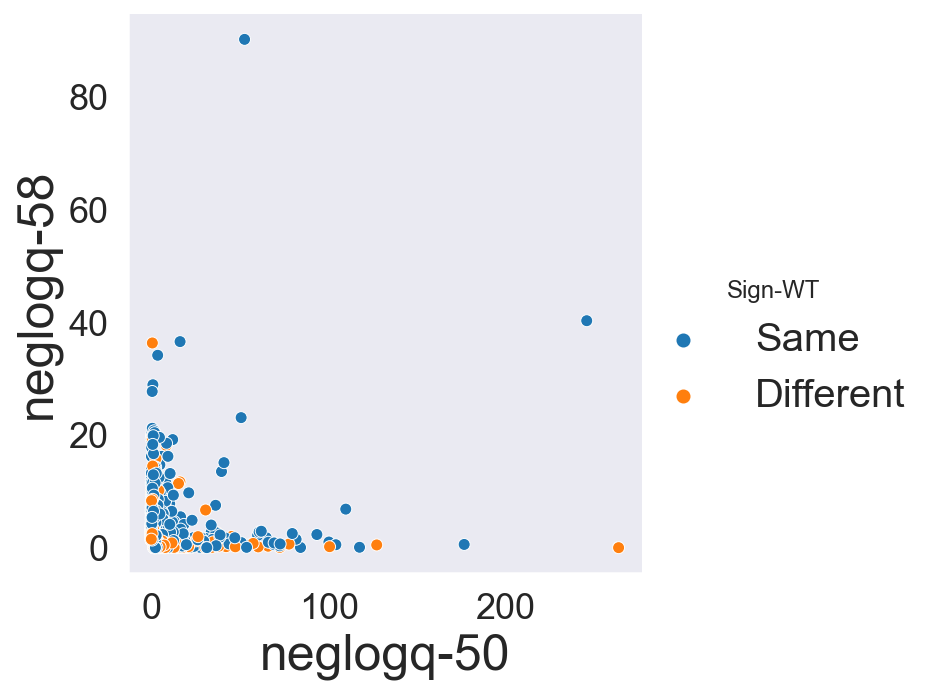

In [3]:
res = res[(res['padj-50'] < 0.05) | (res['padj-58'] < 0.05)]

def save(name, transparent=False):
    plt.savefig('../figs/' + name, bbox_inches='tight', transparent=transparent)

sns.relplot(
    data=res,
    x="neglogq-50", y="neglogq-58",
    kind="scatter", hue='Sign-WT',
)
save('qvals_corr.pdf')

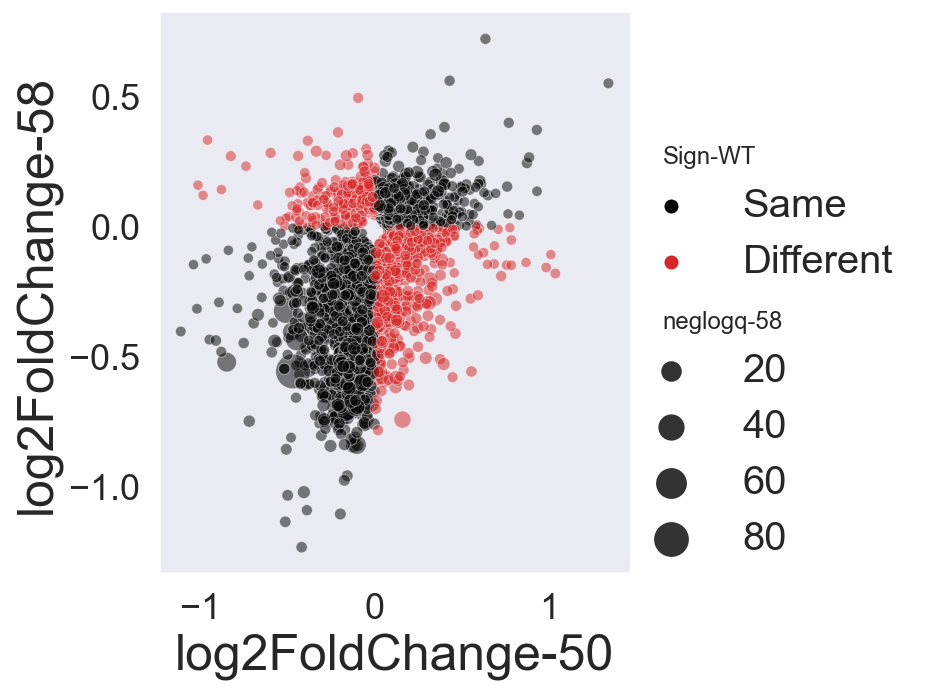

In [4]:
sns.relplot(
    data=res,
    x="log2FoldChange-50", y="log2FoldChange-58",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Sign-WT',
    palette=['black', 'tab:red'], hue_order=['Same', 'Different'],
    alpha=0.5
)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


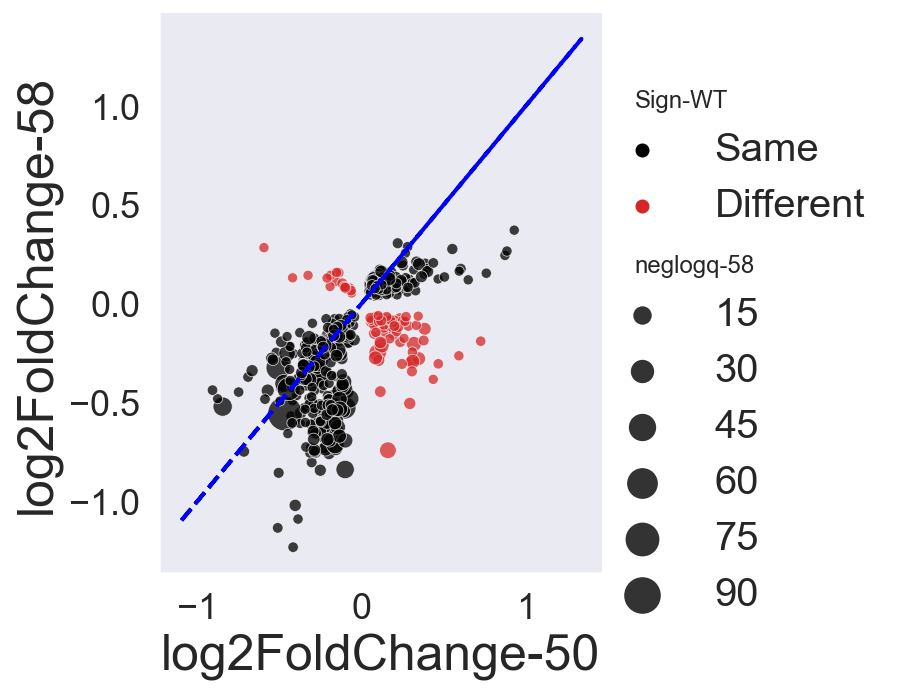

In [7]:
sns.relplot(
    data=res[(res['padj-58'] < 0.05) & (res['padj-50'] < 0.05)],
    x="log2FoldChange-50", y="log2FoldChange-58",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Sign-WT',
    palette=['black', 'tab:red'], hue_order=['Same', 'Different'],
    alpha=0.75,
)

plt.plot(res['log2FoldChange-50'], 1 * res['log2FoldChange-50'],
         label='50hrs = 58hrs', color='blue', ls='--')

save('LFC_corr_intersection.svg')

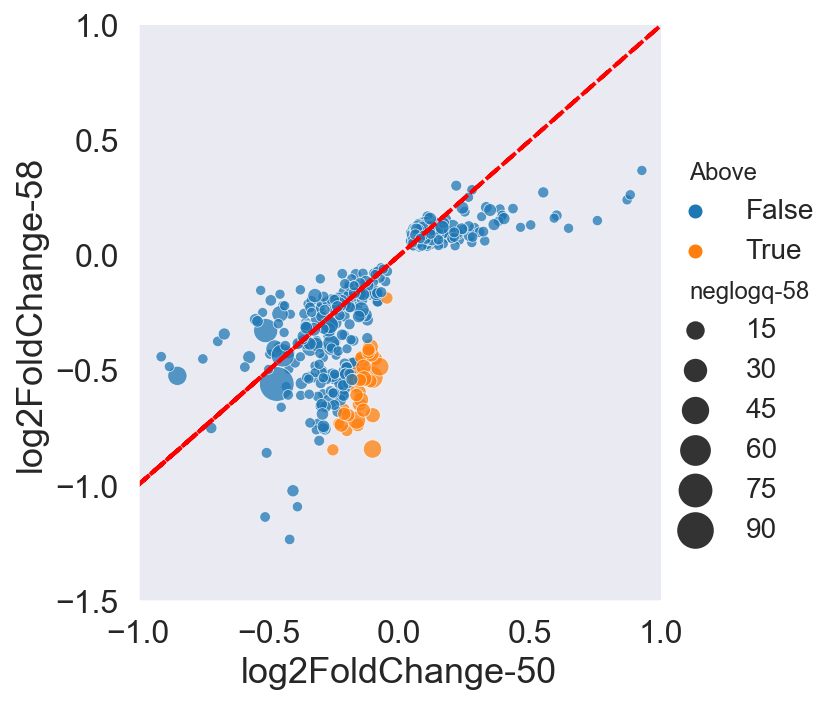

In [5]:
res = res[res['Sign-WT'] == 'Same']

sig = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05)

sns.relplot(
    data=res[sig],
    x="log2FoldChange-50", y="log2FoldChange-58",
    size='neglogq-58', hue='Above',
    kind="scatter", sizes=(25, 300),# hue='Significance',
    alpha=0.75
)

plt.plot(res['log2FoldChange-50'], 1 * res['log2FoldChange-50'],
         label='50hrs = 58hrs', color='red', ls='--')
plt.xlim(-1, 1)
plt.ylim(-1.5, 1)

save('LFC_corr_intersection-clean.pdf')

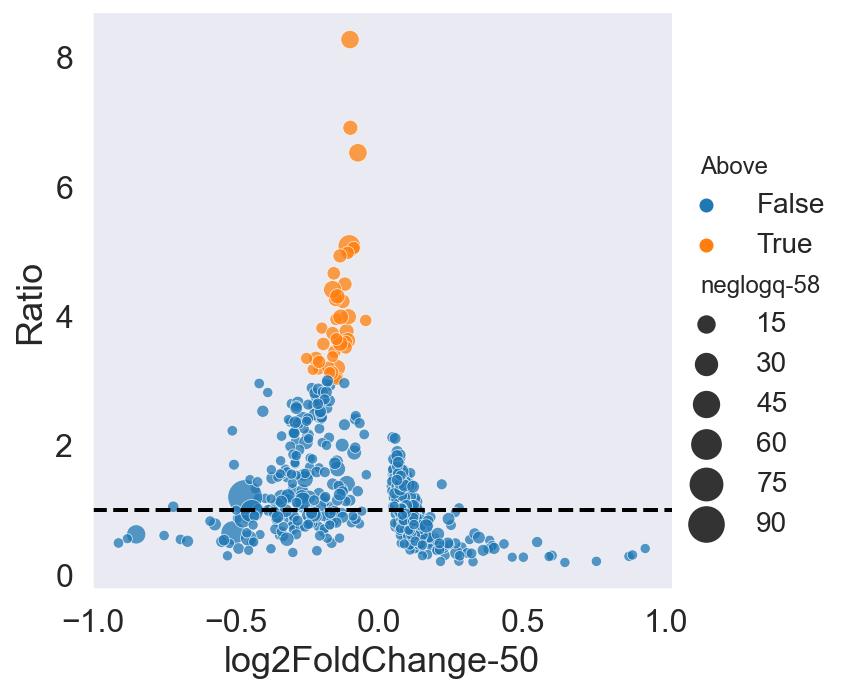

In [6]:
sig = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05)

sns.relplot(
    data=res[(sig)],
    x="log2FoldChange-50", y="Ratio",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Above',
    alpha=0.75
)

plt.axhline(1, color='black', ls='--')
save('ratio_vs_LFC50.pdf')

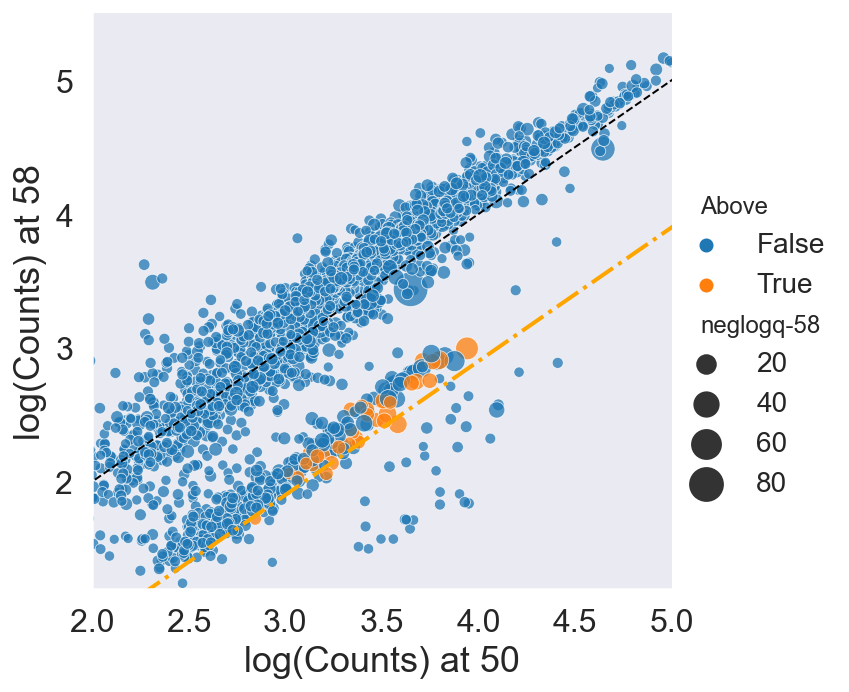

In [10]:
sns.relplot(
    data=res,#[(sig)],
    x="logBM-50", y="logBM-58",
    size='neglogq-58',
    kind="scatter", sizes=(25, 300), hue='Above',
    alpha=0.75
)

x = np.array([0, 6])
plt.plot(x, x,
         color='black', ls='--', lw=1,
         label='Expr 50hrs = Expr 58hrs')

plt.plot(x, x - 1.1,
         color='orange', ls='-.', lw=2,
         label='Expr 50hrs = Expr 58hrs')

plt.xlim(2, 5)
plt.ylim(1.2, 5.5)
plt.xlabel('log(Counts) at 50')
plt.ylabel('log(Counts) at 58')

save('mean-counts-50vs58.pdf')

(1.0, 6.0)

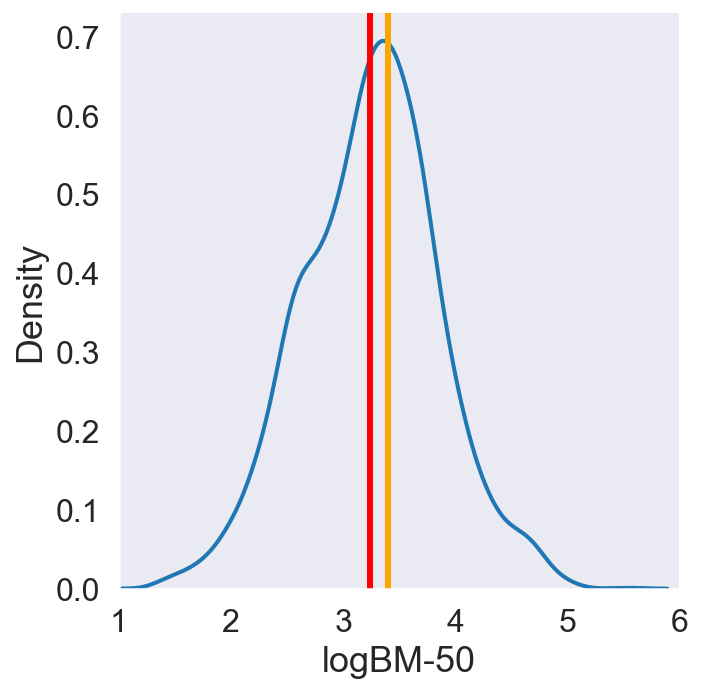

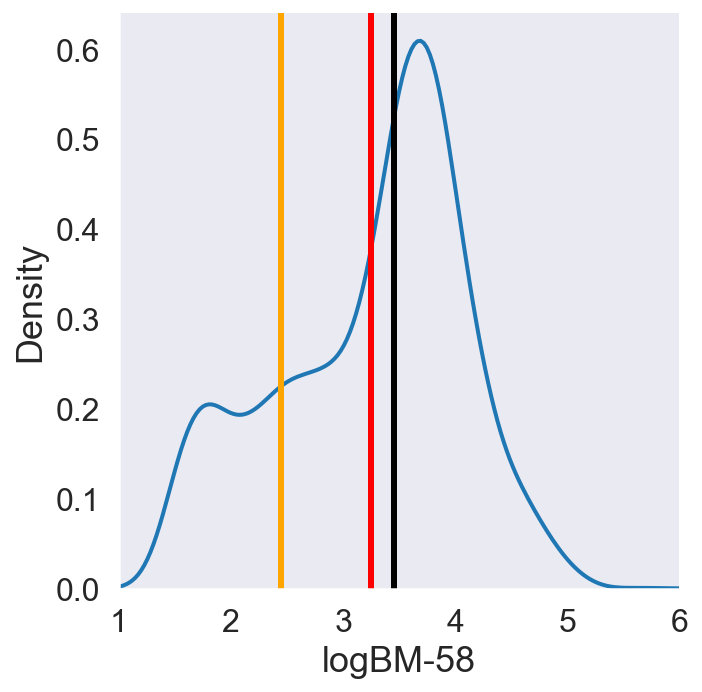

In [11]:
sns.displot(data=res, x='logBM-50', kind='kde')
plt.axvline(res[res.Above == True]['logBM-50'].mean(),
            lw=3, color='orange')
plt.axvline(res['logBM-50'].mean(),
            lw=3, color='red')
plt.xlim(1, 6)

sns.displot(data=res, x='logBM-58', kind='kde')
plt.axvline(res['logBM-58'].mean(),
            lw=3, color='red')
plt.axvline(np.median(res['logBM-58']),
            lw=3, color='black')

plt.axvline(res[res.Above == True]['logBM-58'].mean(),
            lw=3, color='orange')
plt.xlim(1, 6)
